In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
import numpy as np
import pandas as pd
import seaborn as sns

import sys
sys.path.append("/code/")
from thalamus_merfish_analysis import abc_load as abc
from thalamus_merfish_analysis import ccf_images as cimg
from thalamus_merfish_analysis import ccf_plots as cplots
from thalamus_merfish_analysis import ccf_erode as cerd
from thalamus_merfish_analysis import diversity_metrics as divmet
from thalamus_merfish_analysis import diversity_plots as dplot
import thalamus_merfish_analysis.distance_metrics as dm


from matplotlib import rcParams
rcParams['ps.fonttype'] = 42
rcParams['pdf.fonttype'] = 42
rcParams['font.size'] = 7

import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline') 

## Load thalamus data

In [23]:
obs_wmb = abc.get_combined_metadata()
obs_th = abc.load_standard_thalamus(data_structure='obs')

/code/thalamus_merfish_analysis/abc_load_base.py:336: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  cells_df = cells_df.replace("ZI-unassigned", "ZI")
/code/thalamus_merfish_analysis/abc_load_base.py:336: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  cells_df = cells_df.replace("ZI-unassigned", "ZI")


In [24]:
# set spatial column names to `_reconstructed` coordinate space
coords = '_reconstructed'

x_col = 'x'+coords
y_col = 'y'+coords
z_col = 'z'+coords
section_col = 'brain_section_label'

In [25]:
# Load the CCF structures image
ccf_images = abc.get_ccf_labels_image()

# we only need to load the boundaries for sections that contain the thalamus
sections_all = sorted(obs_th[z_col].unique())
sections_int = np.rint(np.array(sections_all)/0.2).astype(int)

# precompute boundaries for thalamic sections
ccf_boundaries = cimg.sectionwise_label_erosion(ccf_images, distance_px=1, 
                                                fill_val=0, return_edges=True, 
                                                section_list=sections_int
                                                )

In [26]:
# We can load & use the published color palettes for the ABC Atlas taxonomy
abc_palettes = {level: abc.get_taxonomy_palette(level) for level in 
                ['neurotransmitter','class', 'subclass','supertype','cluster']}

# We have also provided a secondary color palette for the cluster level that 
# attempts to increase the color contrast between spatially negihboring clusters
abc_palettes['cluster'] = abc.get_thalamus_cluster_palette() #dict(zip(palette_df['Unnamed: 0'], palette_df['0']))

ccf_palette = abc.get_ccf_palette('substructure')
ccf_palette['ZI'] = ccf_palette.pop('ZI-unassigned') # need to fix a key error

In [29]:
# We'll use the eroded CCF structures to calculate similarity metrics
ccf_metrics_level = "structure"
obs_erode, ccf_label_eroded = cerd.label_cells_by_eroded_ccf(obs_th, ccf_images, ccf_level=ccf_metrics_level, distance_px=5) # default is erosion by 5px (50um)

# There is poor alignment in section 6.6 between PF celltypes and the PF CCF structure
# So, we'll set all cells in section 6.6 to 'unassigned' CCF structure
obs_erode.loc[lambda df: df['z_section']==6.6, ccf_label_eroded] = 'unassigned'

In [43]:
# if you reload thalamus_merfish_analysis.ccf_plots after this cell has been run, 
# cplots.CCF_REGIONS_DEFAULT will be reset to None & you'll need to re-run this cell
cplots.CCF_REGIONS_DEFAULT = abc.get_thalamus_names()

In [31]:
results_dir = '../../results'

## Fig 2A-C: 2D heatmaps

In [32]:
regions_to_plot = [
    "AD", "AV", "AM", "IAD", "LD", "VPM", "VPL", "LGd",
    "MD", "CL", "CM", "IMD", "PO", "LP", "VAL", "VM", 
    "RE", "PF", "VPMpc", "PCN", "SPA", "PVT", "MH", "LH", "RT", 
]

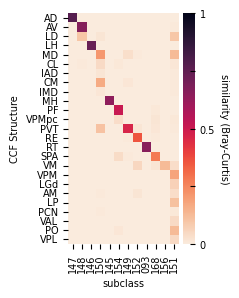

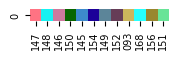

In [33]:
# thalamic nuclei vs subclass similarity
taxonomy_level = 'subclass'
dist, y_names, x_names = dm.cluster_distances_from_labels(
                            obs_erode, y_col=ccf_label, x_col=taxonomy_level, 
                            y_names=sorted(regions_to_plot),
                            x_names=sorted(obs_erode[taxonomy_level].unique()))

y_order, x_order = dm.order_distances_x_to_y(dist, reorder_y=True)

x_names_ids_only = [name[0:3] for name in x_names]

fig_hm_subclass = dm.plot_ordered_similarity_heatmap(dist, 
                                         y_order=y_order, x_order=x_order, 
                                         y_names=y_names, x_names=x_names_ids_only)

fig_hm_subclass.set_size_inches(1.8,3)
fig_hm_subclass.gca().set_xlabel(taxonomy_level)
fig_hm_subclass.gca().set_ylabel('CCF Structure')

fig_hm_subclass.savefig(f'{results_dir}/fig2a_similarity_heatmap_nuclei_vs_{taxonomy_level}_alpha-reorderedY.pdf', 
                        transparent=True, bbox_inches='tight')


# Plot colored labels for the x-axis categories
fig_xlabel_colors = dm.plot_heatmap_xlabel_colors(x_names, 
                                                  x_order, 
                                                  abc_palettes[taxonomy_level])
fig_xlabel_colors.set_size_inches(1.8,3)
fig_xlabel_colors.savefig(f'{results_dir}/fig2a_similarity_heatmap_nuclei_vs_{taxonomy_level}_xaxis_colors.pdf', 
                        transparent=True, bbox_inches='tight')

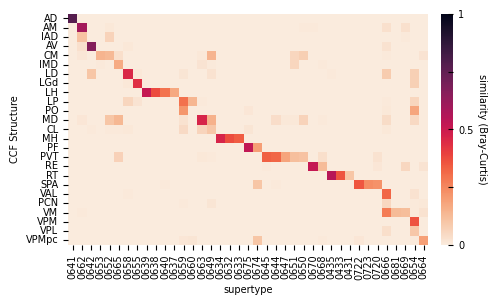

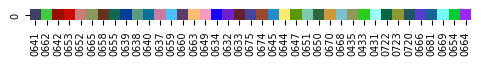

In [34]:
# thalamic nuclei vs supertype similarity
taxonomy_level = 'supertype'
dist, y_names, x_names = dm.cluster_distances_from_labels(
                            obs_erode, y_col=ccf_label, x_col=taxonomy_level, 
                            y_names=sorted(regions_to_plot),
                            x_names=sorted(obs_erode[taxonomy_level].unique()))

y_order, x_order = dm.order_distances_x_to_y(dist, reorder_y=True)

x_names_ids_only = [name[0:4] for name in x_names]

fig_hm_supertype = dm.plot_ordered_similarity_heatmap(
                        dist, 
                        y_order=y_order, x_order=x_order, 
                        y_names=y_names, x_names=x_names_ids_only
                        )

fig_hm_supertype.set_size_inches(5.8,3)
fig_hm_supertype.gca().set_xlabel(taxonomy_level)
fig_hm_supertype.gca().set_ylabel('CCF Structure')


fig_hm_supertype.savefig(f'{results_dir}/fig2b_similarity_heatmap_nuclei_vs_{taxonomy_level}_alpha-reorderedY.pdf', 
                        transparent=True, bbox_inches='tight')


# Plot colored labels for the x-axis categories
fig_xlabel_colors = dm.plot_heatmap_xlabel_colors(x_names, 
                                                  x_order, 
                                                  abc_palettes[taxonomy_level])
fig_xlabel_colors.set_size_inches(5.7,3)
fig_xlabel_colors.savefig(f'{results_dir}/fig2b_similarity_heatmap_nuclei_vs_{taxonomy_level}_xaxis_colors.pdf', 
                          transparent=True, bbox_inches='tight')

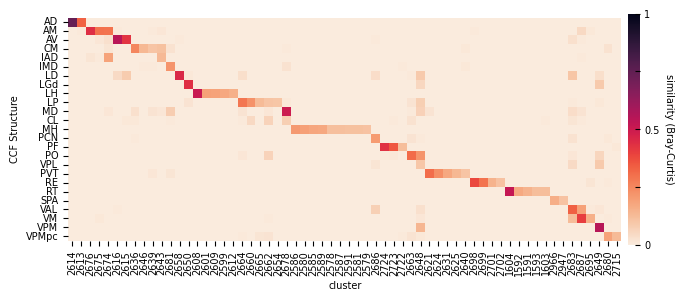

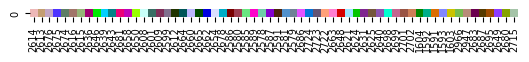

In [35]:
# thalamic nuclei vs cluster similarity
taxonomy_level = 'cluster'
dist, y_names, x_names = dm.cluster_distances_from_labels(
                            obs_erode, y_col=ccf_label, x_col=taxonomy_level, 
                            y_names=sorted(regions_to_plot),
                            x_names=sorted(obs_erode[taxonomy_level].unique()))

y_order, x_order = dm.order_distances_x_to_y(dist, reorder_y=True)

x_names_ids_only = [name[0:4] for name in x_names]

fig_hm_cluster = dm.plot_ordered_similarity_heatmap(dist, 
                                         y_order=y_order, x_order=x_order, 
                                         y_names=y_names, x_names=x_names_ids_only)

fig_hm_cluster.set_size_inches(8.5,3)
fig_hm_cluster.gca().set_xlabel(taxonomy_level)
fig_hm_cluster.gca().set_ylabel('CCF Structure')


fig_hm_cluster.savefig(f'{results_dir}/fig2c_similarity_heatmap_nuclei_vs_{taxonomy_level}_alpha-reorderedY.pdf', 
                        transparent=True, bbox_inches='tight')


# Plot colored labels for the x-axis categories
fig_xlabel_colors = dm.plot_heatmap_xlabel_colors(x_names, 
                                                  x_order, 
                                                  abc_palettes[taxonomy_level])
fig_xlabel_colors.set_size_inches(6.3,3)
fig_xlabel_colors.savefig(f'{results_dir}/fig2c_similarity_heatmap_nuclei_vs_{taxonomy_level}_xaxis_colors.pdf', 
                          transparent=True, bbox_inches='tight')

## Figure 2D,E: Diversity metrics in space

In [36]:
# calculate per-nucleus diversity metrics
th_ccf_metrics = divmet.calculate_diversity_metrics(obs_erode, ccf_label=ccf_label)

# set color map
cmap = sns.color_palette("mako_r", as_cmap=True)

8.0


7.2
6.4


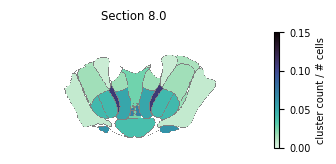

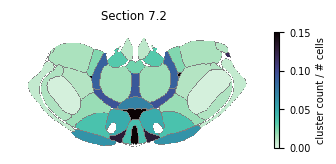

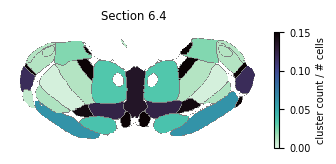

In [46]:
# plot the cell type counts in the CCF structures
sections_to_plot = cplots.TH_EXAMPLE_Z_SECTIONS
plt.rcParams.update({'font.size': 7})
figs_clust_count_norm2cells = cplots.plot_metrics_ccf(ccf_images, 
                                    th_ccf_metrics['count_norm2cells_cluster'], 
                                    sections_to_plot,
                                    ccf_level=ccf_metrics_level,
                                    vmin=0, vmax=0.15, cmap=cmap,
                                    cb_label='cluster count / # cells'
                                    )

for i, fig in enumerate(figs_clust_count_norm2cells):
    fig.set_size_inches(4, 2)
    fig.savefig(f'{results_dir}/fig2d_ccf_cluster_count_norm2cells_sec{int(sections_to_plot[i]*10)}.png',
                transparent=True, bbox_inches='tight', dpi=300)
    
fig.savefig(f'{results_dir}/fig2d_ccf_cluster_count_norm2cells_colorbar.pdf',
            transparent=True, bbox_inches='tight')

In [38]:
# calculate local diversity index using Inverse Simpson's Index (ISI) as metric
local_isi_df = divmet.calculate_local_diversity_metric(obs_erode, 
                                                       divmet.inverse_simpsons_index, 
                                                       metric_name='isi', 
                                                       n_neighbors=15)

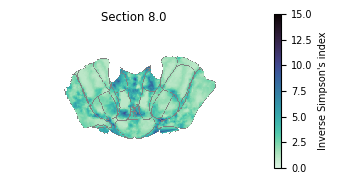

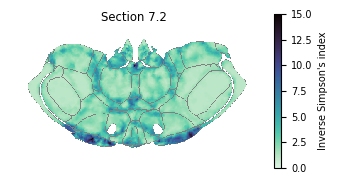

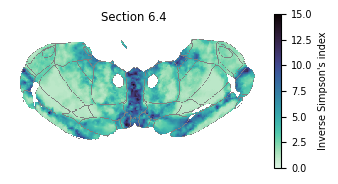

In [39]:
metric_name = 'local_isi_cluster'

for section in cplots.TH_EXAMPLE_Z_SECTIONS:
    fig = dplot.plot_local_metric_ccf_section(obs_erode, local_isi_df, ccf_images,
                                              section, metric_name, cmap=cmap)

    fig.set_size_inches(4, 2)
    fig.savefig(f'{results_dir}/fig2e_ccf_local_isi_cluster_sec{int(section*10)}.png',
                transparent=True, bbox_inches='tight', dpi=300)
    fig.savefig(f'{results_dir}/fig2e_ccf_local_isi_cluster_colorbar.pdf',
                transparent=True, bbox_inches='tight')

## Figure 2F,G: Annotated clusters in example nuclei

In [40]:
# set kwargs fpr annotated cluster plots
kwargs_cluster_annotations = dict(
    bg_cells=obs_th,
    boundary_img=ccf_boundaries,
    section_col=z_col,
    x_col=x_col,
    y_col=y_col,
    point_size=1.5,
    figsize=(4, 2),
    face_palette=None,
    edge_color='silver'
    )

/code/thalamus_merfish_analysis/ccf_plots.py:1017: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  obs = pd.concat(


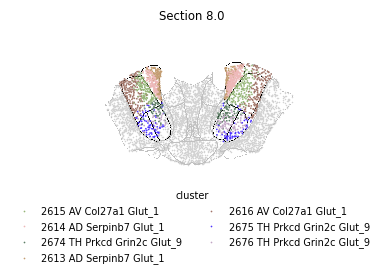

In [41]:
# get the cluster annotations for the nucleus of interest
nucleus = ['AD', 'AM', 'AV']
obs_annot = abc.get_obs_from_annotated_clusters(nucleus, obs_th)

# Let's look at the cell types in the ATN in one sample section
sections_to_plot = [cplots.TH_EXAMPLE_Z_SECTIONS[0]]
nuclei_highlight = ['AD', 'AMd', 'AMv', 'AV', 'AV']
taxonomy_level = 'cluster'

plt.rcParams.update({'font.size': 7})
figs_annot = cplots.plot_ccf_overlay(obs_annot, 
                                    ccf_images, 
                                    ccf_highlight=nuclei_highlight,
                                    point_hue=taxonomy_level, 
                                    sections=sections_to_plot,
                                    point_palette=abc_palettes[taxonomy_level],
                                    legend='cells',
                                    **kwargs_cluster_annotations)
figs_annot[0].savefig(f'{results_dir}/fig2f_cluster_annotations_z80_ATN.pdf', 
                      transparent=True, bbox_inches='tight')
figs_annot[0].savefig(f'{results_dir}/fig2f_cluster_annotations_z80_ATN.png', 
                      transparent=True, bbox_inches='tight', dpi=1200)

/code/thalamus_merfish_analysis/ccf_plots.py:1017: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  obs = pd.concat(


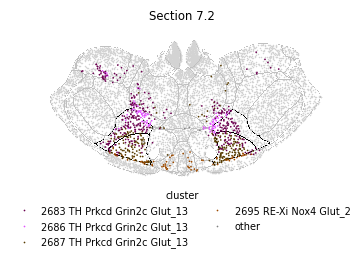

In [42]:
# get the cluster annotations for the nucleus of interest
nucleus = ['VAL', 'VM']
obs_annot = abc.get_obs_from_annotated_clusters(nucleus, obs_th)

# Let's look at the cell types in the ATN in one sample section
sections_to_plot = [cplots.TH_EXAMPLE_Z_SECTIONS[1]]
nuclei_highlight = nucleus
taxonomy_level = 'cluster'

figs_annot = cplots.plot_ccf_overlay(obs_annot, 
                                    ccf_images, 
                                    ccf_highlight=nuclei_highlight,
                                    point_hue=taxonomy_level, 
                                    sections=sections_to_plot,
                                    point_palette=abc_palettes[taxonomy_level],
                                    legend='cells',
                                    **kwargs_cluster_annotations)

figs_annot[0].savefig(f'{results_dir}/fig2f_cluster_annotations_z72_VAL_VM.pdf',
                      transparent=True, bbox_inches='tight')
figs_annot[0].savefig(f'{results_dir}/fig2f_cluster_annotations_z72_VAL_VM.png',
                      transparent=True, bbox_inches='tight', dpi=1200)